In [1]:
import pandas as pd
import math
import numpy as np
import time

import seaborn as sns

import numpy as np
from sklearn.manifold import TSNE
from sklearn.manifold import MDS

from sklearn.manifold import spectral_embedding

In [2]:
name = 'NBA'
output_folder  = '{}/{}'.format('data', name)
simFile = '{}/similarity'.format(output_folder)

In [3]:
insight_df = pd.read_csv('./rawData/{}/insight.csv'.format(name))
subspace_df = pd.read_csv('./rawData/{}/subspace.csv'.format(name))

# insight_columns: insights columns
# subspace_columns: subspaces

insight_columns = insight_df.columns[:10]
subspace_columns = subspace_df.columns

result_df = insight_df[insight_columns].merge(subspace_df, left_on='sid', right_on='sid')
result_df['index'] = result_df.index

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (1,3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
result_df.columns

Index(['breakdown', 'breakdown_value', 'measure', 'sig', 'impact', 'insight',
       'insight_type', 'score', 'iid', 'sid', 'name', 'year', 'team_name',
       'age', 'lg_name', 'pos_name', 'index'],
      dtype='object')

In [5]:
# A: features used  to calculate similarity
# M: the size of data

A = list(subspace_columns)[:-1] + ['breakdown', 'measure', 'insight'] 
N = result_df.shape[0]

In [6]:
subspace_range = [0, len(subspace_columns)]

In [7]:
subspace_len = len(subspace_columns)
print(A)
print(subspace_len, len(A))

['name', 'year', 'team_name', 'age', 'lg_name', 'pos_name', 'breakdown', 'measure', 'insight']
7 9


In [34]:
# function f(k, x); funciton p(k, x) p2(k, x)

kx_map = {}
for (k, a) in enumerate(A):
    if k not in kx_map:
        kx_map[k] = {}
    x_count = result_df[[a, 'index']].groupby(a).count().reset_index()
    for obj in x_count.to_dict('records'):
        kx_map[k][obj[a]] = obj['index']
        
        
def f(k, x):
    if k not in kx_map:
        return False
    if x not in kx_map[k]:
        return 0
    return kx_map[k][x]

insight_records= result_df.to_dict('records')

def p(k, x):
    fkx = f(k, x)
    if fkx == False:
        return False
    return fkx / N

def p2(k, x):
    fkx = f(k,x)
    if fkx == False:
        return False
    return fkx * (fkx-1) / (N * (N-1)) 

def linw(src, dst):
    s = 0
    for (k, a) in enumerate(A):
        Xk, Yk =  src[a], dst[a]
        s += (np.log(p(k, Xk)) + np.log(p(k, Yk))) 
    return 1/s 

def linS(k, src, dst):
    key = A[k]
    Xk, Yk = src[key], dst[key]
    if Xk == Yk:
        return 2 * np.log(p(k, Xk))
    return 2*np.log2(p(k, Xk) + p(k, Yk))

# def lin(src, dst):
#     w = linw(src, dst)
#     sim = 0
#     print(w)
#     for (k, a) in enumerate(A):
# #         if k < subspace_len:
# #             w *= 1 / len(subspace_columns)
#         print('---', A[k], linS(k, src, dst), w*linS(k, src, dst), src[a], dst[a])
#         sim += w*(linS(k, src, dst))
#     print("sum", sim)
#     print('\n')
#     return sim

def lin(src, dst):
    w = linw(src, dst)
    sim = 0
    print(w)
    for (k, a) in enumerate(A):
#         if k < subspace_len:
#             w = w*( 1 / len(subspace_columns))
             
        print('---', A[k], linS(k, src, dst), w*linS(k, src, dst), src[a], dst[a])
        sim += w*(linS(k, src, dst))
    print("sum", sim)
    print('\n')
    return sim



In [35]:
simMatrix = np.zeros((N, N))
start_time = time.time()

for i in range(0, len(insight_records)):
    src = insight_records[i]
    for j in range(i, len(insight_records)):
        if i == j:
            simMatrix[i][j] = 1
        else:
            dst = insight_records[j]
            simMatrix[i][j] = float(lin(src, dst))
            simMatrix[j][i] = simMatrix[i][j]
            print(simMatrix)
        if j > 4:
            break
    break
end_time = time.time()
print('use time ', end_time - start_time)

-0.04936865299109286
--- name 0.0 -0.0 * *
--- year 0.0 -0.0 * *
--- team_name -10.756720148443145 0.5310447843307865 Chicago Bulls Chicago Bulls
--- age -0.7803952719547518 0.03852706337702368 * *
--- lg_name -0.04023072259415164 0.0019861365833315917 NBA *
--- pos_name -0.6315300823892126 0.03117778949090932 * *
--- breakdown -1.3557594168583138 0.06693201619028451 year year
--- measure -1.5463797764669633 0.07634268657684126 PTS PTS
--- insight -3.7436043538031827 0.18481670427885374 Trend Trend
sum 0.9308271808280307


[[1.         0.93082718 0.         ... 0.         0.         0.        ]
 [0.93082718 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
-0.04585816865240907
--- na

In [21]:
simMatrix

array([[1.        , 0.93082718, 0.85099072, ..., 1.06631311, 0.42944929,
        0.49941768],
       [0.93082718, 1.        , 0.91394013, ..., 0.99786655, 0.39597731,
        0.46070161],
       [0.85099072, 0.91394013, 1.        , ..., 0.91285233, 0.36040543,
        0.41421397],
       ...,
       [1.06631311, 0.99786655, 0.91285233, ..., 1.        , 0.48987836,
        0.57161326],
       [0.42944929, 0.39597731, 0.36040543, ..., 0.48987836, 1.        ,
        0.8506611 ],
       [0.49941768, 0.46070161, 0.41421397, ..., 0.57161326, 0.8506611 ,
        1.        ]])

In [22]:
# def generate_projection(sim_matrix, perplexity = 12):
    
#     st = time.time()
#     X_embedded = TSNE(n_components=2, 
#                    init='random', perplexity=perplexity).fit_transform(sim_matrix)

# #     X_embedded = MDS(n_components=2).fit_transform(sim_matrix)
    
# #     X_embedded = spectral_embedding(sim_matrix, n_components=2)
#     print(time.time() - st)
#     return X_embedded

def visualize_matrix(projection):
    df = pd.DataFrame(columns=['x', 'y'], data=projection)
    sns.scatterplot(data=df, x="x", y="y")

def calc_projection(sim, index_list, perplexity = 50):
    matrix = sim if type(sim) != str else np.load(simFile.format(output_folder, 'npz'))
    sub_matrix = matrix[index_list][:, index_list]
    X_embedded = generate_projection(sub_matrix, perplexity)
    return X_embedded

In [30]:
def generate_projection(sim_matrix, perplexity = 12):
    
    st = time.time()
#     X_embedded = TSNE(n_components=2, 
#                    init='random', perplexity=perplexity).fit_transform(sim_matrix)

    X_embedded = MDS(n_components=2).fit_transform(sim_matrix)
    
#     X_embedded = spectral_embedding(sim_matrix, n_components=2)
    print(time.time() - st)
    return X_embedded


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_mds.py:441: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


6.409987211227417


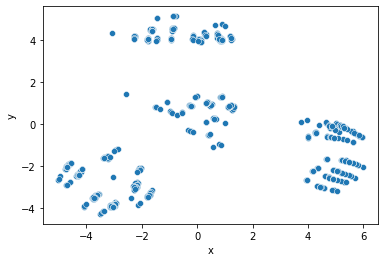

In [31]:
projection = calc_projection(simMatrix, [i for i in range(0, 650)], perplexity=15)
visualize_matrix(projection)

In [17]:
# np.savez("{}/{}.npz".format(output_folder, 'projection'), projection = projection)

In [ ]:
type('123') == str

In [ ]:
emb = calc_projection(simMatrix, [i for i in range(0, 649)], perplexity=12)
visualize_matrix(emb)

In [ ]:
test_index = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
test_index = [i for i in range(0, 374)]
sub_similarity = simMatrix[test_index][:, test_index]

In [ ]:
sub_similarity

In [ ]:
X_embedded = generate_projection(sub_similarity, 99)
visualize_matrix(X_embedded)

In [ ]:
simMatrix[[1,2,3]][:, [1,2,3]].shape

In [ ]:
simMatrix[[1,5,7]][:, [1,5,7]]

In [ ]:
simMatrix[[1]]

## Save similarity matrix

In [ ]:

start_time = time.time()
X_embedded = TSNE(n_components=2, 
                   init='random', perplexity=12).fit_transform(simMatrix)
print("Use time: ", time.time() - start_time)

projection = pd.DataFrame(columns=['x', 'y'], data = X_embedded)
sns.scatterplot(data=projection, x="x", y="y")

In [ ]:
result_df[['x', 'y']] = projection.values
result_df.to_csv('projection.csv', index = False)

In [ ]:
def generate_projection():
    pass

## process subspace

In [ ]:
sub_df = result_df[result_df['team_name'] == 'Los Angeles Lakers']

sub_N = sub_df.shape[0]
sub_simMatrix = np.zeros((sub_N, sub_N))
start_time = time.time()
sub_insight_records = sub_df.to_dict('records')
for i in range(0, len(sub_insight_records)):
    src = sub_insight_records[i]
    for j in range(i+1, len(sub_insight_records)):
        dst = sub_insight_records[j]
        sub_simMatrix[i][j] = float(lin(src, dst))
        sub_simMatrix[j][i] = sub_simMatrix[i][j]

end_time = time.time()
print('use time ', end_time - start_time)

In [ ]:
tart_time = time.time()
sub_embedded = TSNE(n_components=2, 
                   init='random', perplexity=5).fit_transform(sub_simMatrix)
print("Use time: ", time.time() - start_time)

sub_projection = pd.DataFrame(columns=['x', 'y'], data = sub_embedded)
sns.scatterplot(data=sub_projection, x="x", y="y")

In [ ]:
sub_df[['x', 'y']] = sub_projection.values
sub_df.to_csv('subspace.csv', index = False)

## breakdown subspace

In [ ]:
result_df['breakdown'].unique()

In [ ]:
result_df[['breakdown','age']].groupby('breakdown').count()

In [ ]:
result_df[['lg_name','age']].groupby('lg_name').count()

In [ ]:
breakdown_df = result_df[result_df['breakdown'] == 'lg_name']

breakdown_N = breakdown_df.shape[0]
breakdown_simMatrix = np.zeros((breakdown_N, breakdown_N))
start_time = time.time()
breakdown_insight_records = breakdown_df.to_dict('records')
for i in range(0, len(breakdown_insight_records)):
    src = breakdown_insight_records[i]
    for j in range(i+1, len(breakdown_insight_records)):
        dst = breakdown_insight_records[j]
        breakdown_simMatrix[i][j] = float(lin(src, dst))
        breakdown_simMatrix[j][i] = breakdown_simMatrix[i][j]
        

end_time = time.time()
print('use time ', end_time - start_time)

In [ ]:
tart_time = time.time()
breakdown_embedded = TSNE(n_components=2, 
                   init='random', perplexity=50).fit_transform(breakdown_simMatrix)
print("Use time: ", time.time() - start_time)

breakdown_projection = pd.DataFrame(columns=['x', 'y'], data = breakdown_embedded)
sns.scatterplot(data=breakdown_projection, x="x", y="y")

In [ ]:
breakdown_df[['x', 'y']] = breakdown_projection.values
breakdown_df.to_csv('breakdown.csv', index = False)

## breakdown  and  subspace

In [ ]:
bs_df = result_df[(result_df['breakdown'] == 'lg_name')&(result_df['team_name'] == 'Los Angeles Lakers')]

bs_N = bs_df.shape[0]
bs_simMatrix = np.zeros((bs_N, bs_N))
start_time = time.time()
bs_insight_records = bs_df.to_dict('records')
for i in range(0, len(bs_insight_records)):
    src = bs_insight_records[i]
    for j in range(i+1, len(bs_insight_records)):
        dst = bs_insight_records[j]
        bs_simMatrix[i][j] = float(lin(src, dst))
        bs_simMatrix[j][i] = bs_simMatrix[i][j]
        

# end_time = time.time()
# print('use time ', end_time - start_time)

In [ ]:
tart_time = time.time()
bs_embedded = TSNE(n_components=2, 
                   init='random', perplexity=50).fit_transform(bs_simMatrix)
print("Use time: ", time.time() - start_time)

bs_projection = pd.DataFrame(columns=['x', 'y'], data = bs_embedded)
sns.scatterplot(data=bs_projection, x="x", y="y")

In [ ]:
bs_df[['x', 'y']] = bs_projection.values
bs_df.to_csv('bs.csv', index = False)

In [ ]:
result_df['year'].shape